# Importing Necessary Frameworks and Loading the Datasets

In [ ]:
import boto3
import pandas as pd
from io import BytesIO
from io import StringIO
import seaborn as sns

# Initialize a boto3 client with your AWS credentials
# Access key ID & Secret access key shared in your mail
s3_client = "secret"

bucket_name = 'datathon-3.0'

file_list = ["Q1-customers.csv","Q1-submission.csv","Q2-new-products.csv","Q2-submission.csv","Q4A-submission.csv","Q4B-submission.csv","TBL_CUSTOMER_PROFILE.csv", "TBL_PACK_PURCHASE.csv","TBL_PRODUCT_CATALOGUE.csv","TBL_DATA_CONSUMPTION.csv"]
for i, file in enumerate(file_list):
    print(i, file)


profile = file_list[6]
response = s3_client.get_object(Bucket=bucket_name, Key=profile)
profile = pd.read_csv(BytesIO(response['Body'].read()))

purchase = file_list[7]
response = s3_client.get_object(Bucket=bucket_name, Key=purchase)
purchase = pd.read_csv(BytesIO(response['Body'].read()))

catal = file_list[8]
response = s3_client.get_object(Bucket=bucket_name, Key=catal)
catal = pd.read_csv(BytesIO(response['Body'].read()))

catal['SERVICE_TYPE'] = catal['SERVICE_TYPE'].map({'Premium':1, 'Standard':0})
catal['PRODUCT_STATUS'] = catal['PRODUCT_STATUS'].map({'Continue':1, 'Discontinue':0, 'New':2})
catal['PAYMENT_METHOD'] = catal['PAYMENT_METHOD'].map({'Credit Card':3, 'Mobile Walet':2, 'Digital Wallets':1, 'Cash':0})
catal['per_GB'] = catal['PACK_PRICE'] / catal['DATA_VOL_GB']
catal['gigs_per_day'] = catal['DATA_VOL_GB'] / catal['VALIDITY']
new = catal[catal['PRODUCT_STATUS'] == 2].reset_index(drop=True)
old = catal[catal['PRODUCT_STATUS'] != 2].reset_index(drop=True)

cons = file_list[9]
response = s3_client.get_object(Bucket=bucket_name, Key=cons)
cons = pd.read_csv(BytesIO(response['Body'].read()))

customer_1 = file_list[0]
response = s3_client.get_object(Bucket=bucket_name, Key=customer_1)
customer_1 = pd.read_csv(BytesIO(response['Body'].read()))

sample_1 = file_list[1]
response = s3_client.get_object(Bucket=bucket_name, Key=sample_1)
sample_1 = pd.read_csv(BytesIO(response['Body'].read()))

0 Q1-customers.csv
1 Q1-submission.csv
2 Q2-new-products.csv
3 Q2-submission.csv
4 Q4A-submission.csv
5 Q4B-submission.csv
6 TBL_CUSTOMER_PROFILE.csv
7 TBL_PACK_PURCHASE.csv
8 TBL_PRODUCT_CATALOGUE.csv
9 TBL_DATA_CONSUMPTION.csv


# Feature Engineering 

In [2]:
df = purchase.copy()
avg = cons.groupby('CUSTOMER_ID')['TOTAL_VOLUME_GB'].mean()
df = df.merge(avg.rename('avg_daily') ,on='CUSTOMER_ID', how='left')
df = pd.merge(df, catal, on='PACK_ID', how='left')

df = df[df['CUSTOMER_ID'].isin(customer_1['CUSTOMER_ID'])]

all_prev = df.groupby('CUSTOMER_ID')['PRODUCT_STATUS'].mean()
df = df.merge(all_prev.rename('all_prev_continued'), on='CUSTOMER_ID', how='left')
df['all_prev_continued'] = df['all_prev_continued'] == 0

num_uniq = df.groupby('CUSTOMER_ID')['PACK_ID'].nunique()
df = df.merge(num_uniq.rename('num_uniq_packs'), on='CUSTOMER_ID', how='left')

df['num_purchase'] = df.groupby('CUSTOMER_ID')['CUSTOMER_ID'].transform('count')
df['uniqmore5'] = df['num_uniq_packs'] > 10

df

,EVENT_DATE,CUSTOMER_ID,PACK_ID,HITS,avg_daily,SERVICE_TYPE,PAYMENT_METHOD,PACK_PRICE,VALIDITY,DATA_VOL_GB,PRODUCT_STATUS,per_GB,gigs_per_day,all_prev_continued,num_uniq_packs,num_purchase,uniqmore5
0,20190522,CD1F932E0A89C1,1524,1,7.652201,0,0,994,30,168.0,0,5.916667,5.600000,True,5,5,False
1,20190623,CD1F7B4DD83C5B,1524,1,14.108168,0,0,994,30,168.0,0,5.916667,5.600000,True,3,4,False
2,20190621,CD1F931C4A1659,1524,1,10.853628,0,0,994,30,168.0,0,5.916667,5.600000,True,3,5,False
3,20190521,CD1F93B34632F6,1524,1,4.599349,0,0,994,30,168.0,0,5.916667,5.600000,True,4,5,False
4,20190620,CD1F86EEBF2EB7,1524,1,11.640205,0,0,994,30,168.0,0,5.916667,5.600000,False,5,6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161965,20190611,CD1FB5630BEE8B,28,1,5.064893,0,2,798,30,80.0,0,9.975000,2.666667,True,7,11,False
161966,20190702,CD1F86E0ADE52E,28,1,0.844812,0,2,798,30,80.0,0,9.975000,2.666667,True,4,4,False
161967,20190906,CD1F7DA0954BB8,28,1,2.635088,0,2,798,30,80.0,0,9.975000,2.666667,True,4,4,False
161968,20190614,CD20173E2F65E6,28,1,1.362598,0,2,798,30,80.0,0,9.975000,2.666667,True,2,3,False


# EDA

## Correlation Matrix to see the interrelations among the features

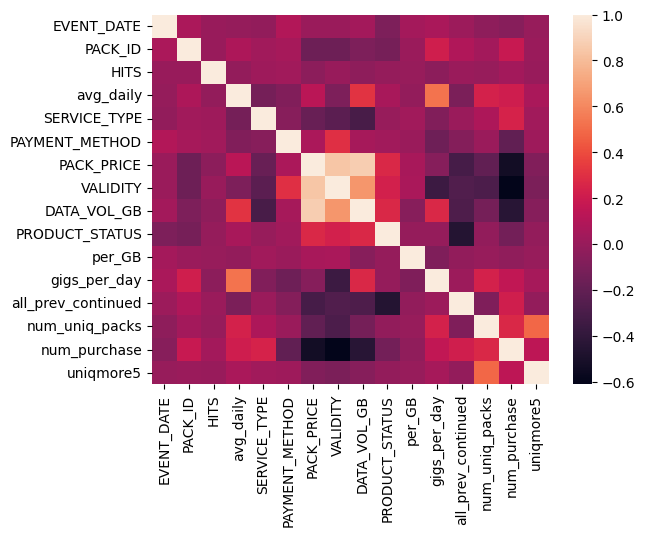

In [3]:
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix);

## Histogram of the Data to View its Distribution

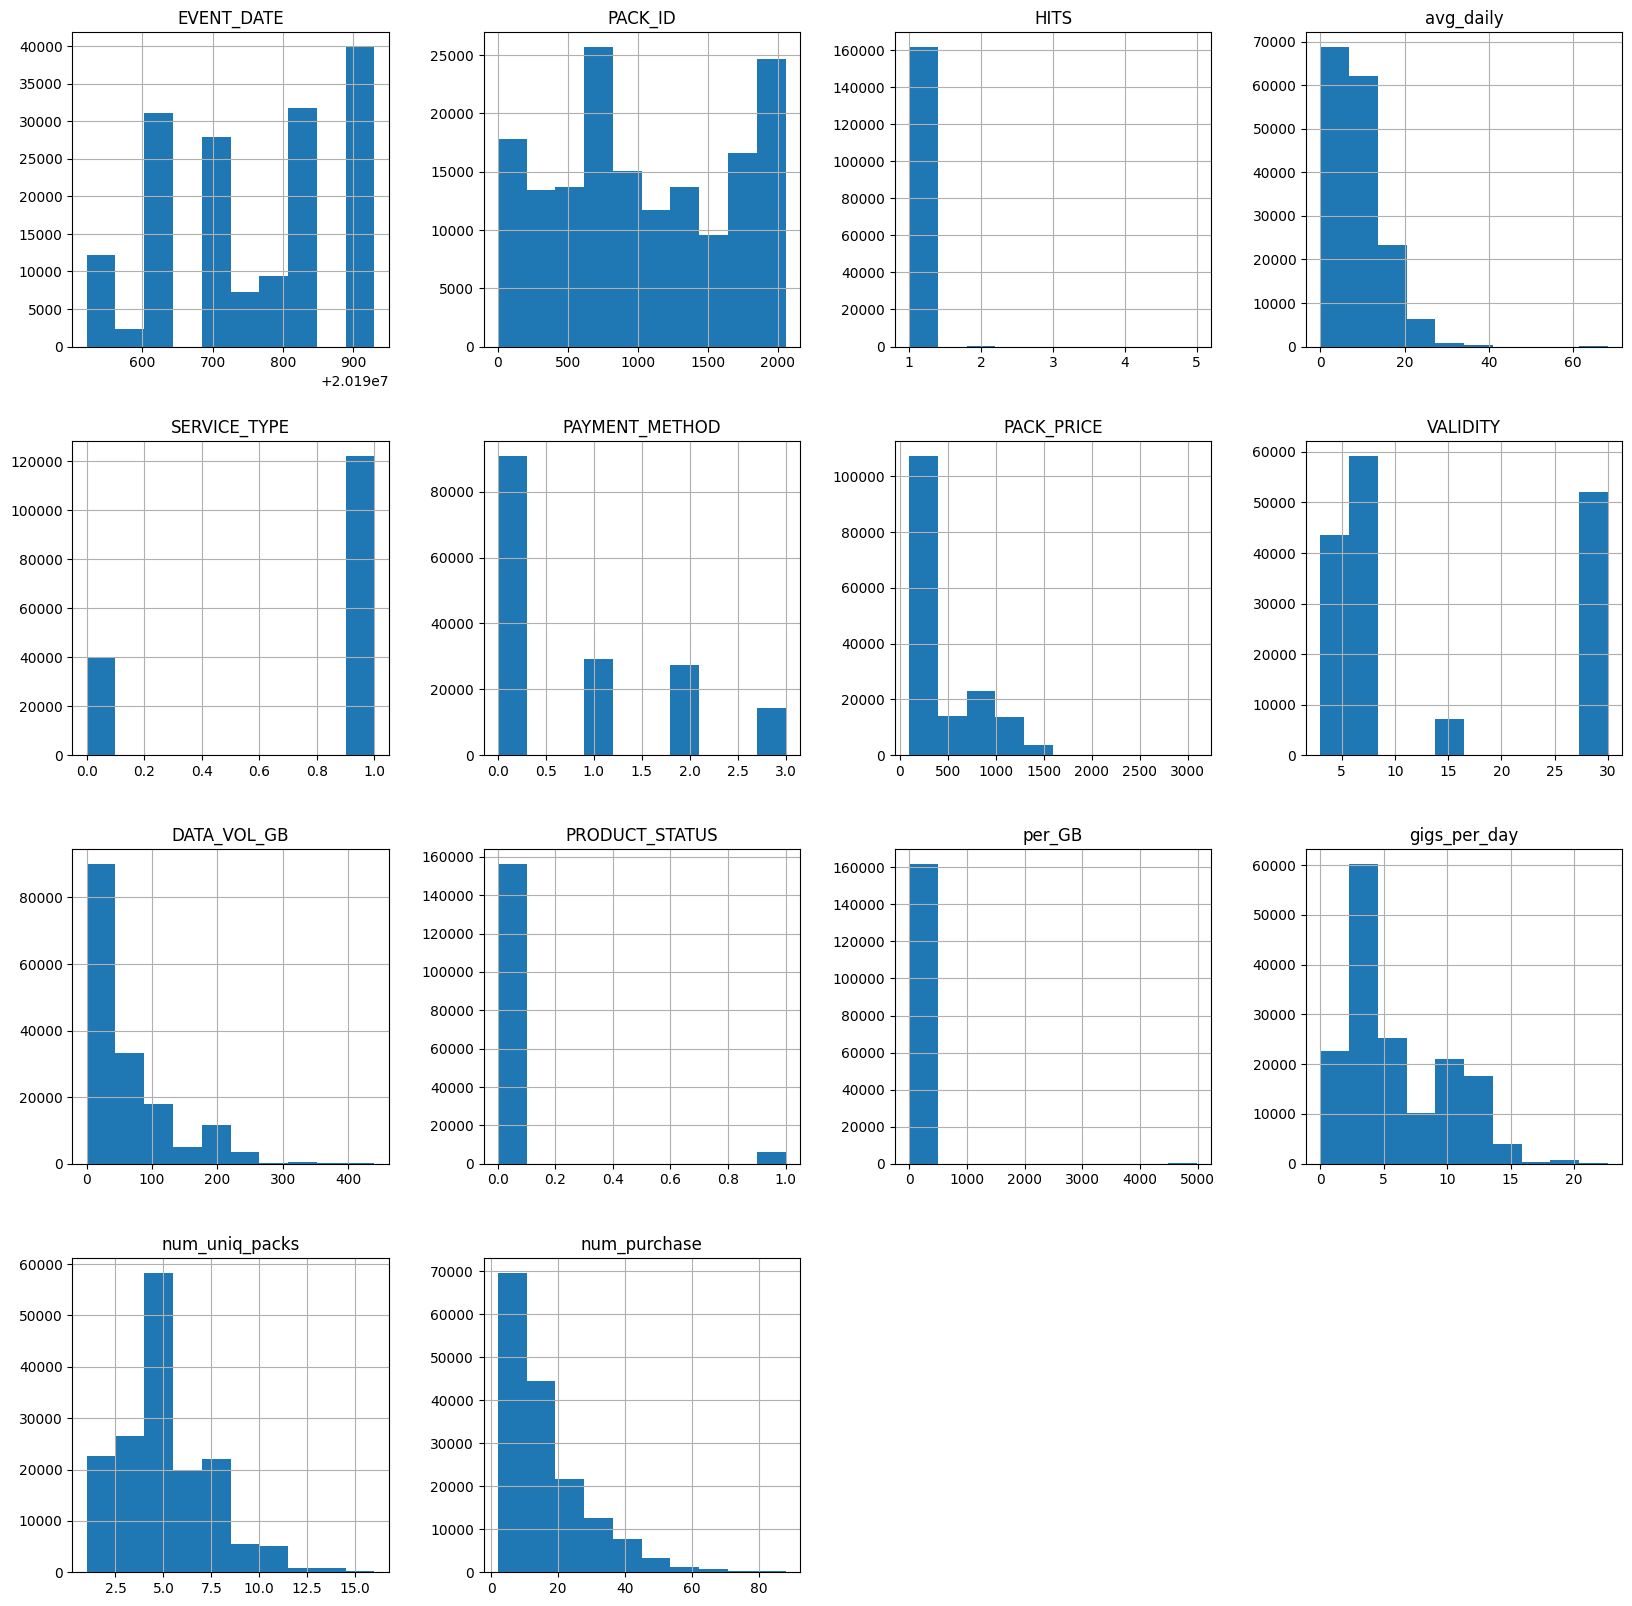

In [4]:
df.hist(figsize=(20,20));

Text(0.5, 1.0, 'PACK_PRICE and DATA_VOL_GB After removing the outliers')

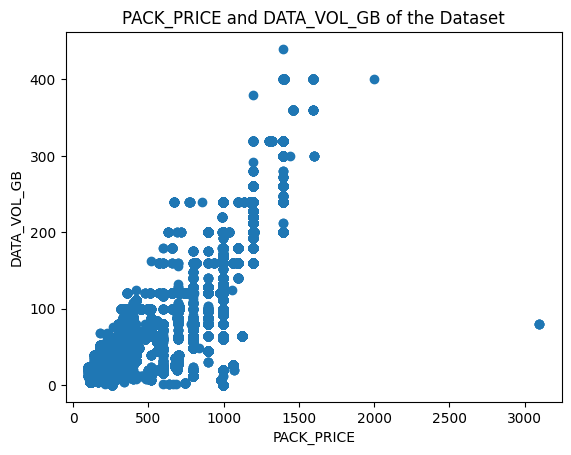

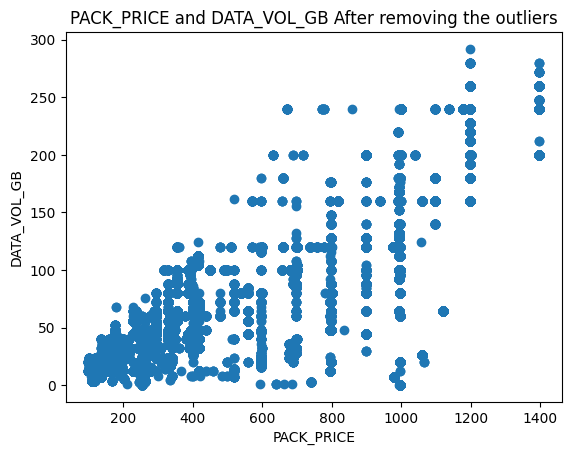

In [5]:
import matplotlib.pyplot as plt
plt.scatter(df['PACK_PRICE'], df['DATA_VOL_GB']);
plt.xlabel('PACK_PRICE')
plt.ylabel('DATA_VOL_GB')
plt.title('PACK_PRICE and DATA_VOL_GB of the Dataset')

df = df[(df['PACK_PRICE'] < 2000) & (df['DATA_VOL_GB']<300)]
plt.figure()
plt.scatter(df['PACK_PRICE'], df['DATA_VOL_GB'], );
plt.xlabel('PACK_PRICE')
plt.ylabel('DATA_VOL_GB')
plt.title('PACK_PRICE and DATA_VOL_GB After removing the outliers')

# BoxPlot

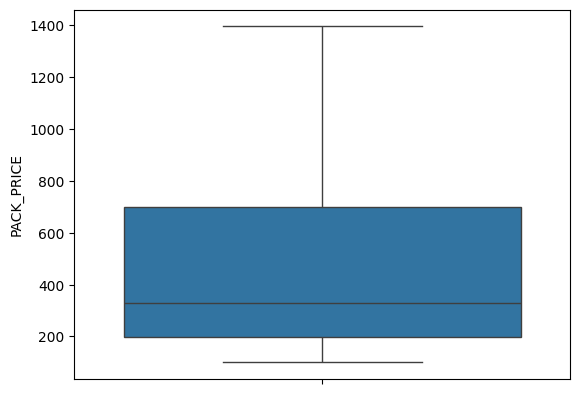

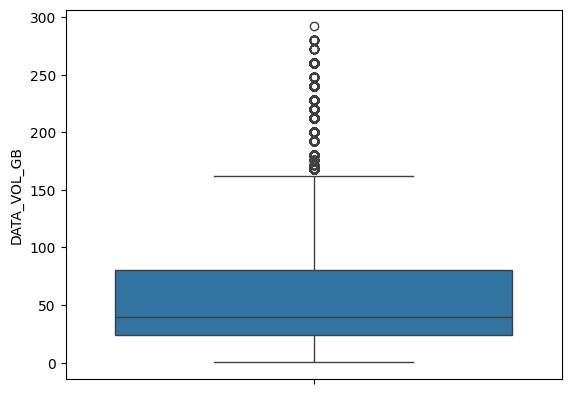

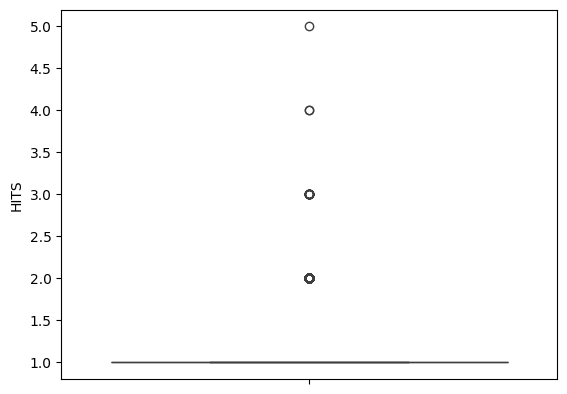

In [6]:
sns.boxplot(df['PACK_PRICE']);
plt.figure()
sns.boxplot(df['DATA_VOL_GB']);
plt.figure()
sns.boxplot(df['HITS']);

# Mapping old data to new data with Unsupervised Clustering

In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

new = catal[catal['PRODUCT_STATUS'] == 2]
new = new.drop(['PRODUCT_STATUS'], axis=1)

old = catal[catal['PRODUCT_STATUS'] != 2]
old = old.drop(['PRODUCT_STATUS'], axis=1)


from sklearn.cluster import KMeans
cls = KMeans(n_clusters=len(new))
cls.fit(sc.fit_transform(new.drop('PACK_ID', axis=1)))


old['equivalent'] = cls.predict(sc.fit_transform(old.drop('PACK_ID', axis=1)))
new['equivalent'] = cls.predict(sc.fit_transform(new.drop('PACK_ID', axis=1)))
old = old[['PACK_ID', 'equivalent']]
new = new[['PACK_ID', 'equivalent']]

merged = old.merge(new, on='equivalent', how='left')
merged = merged.rename(columns={'PACK_ID_x':'PACK_ID'})

# Preparation of Submission File

In [8]:
preds = merged[['PACK_ID', 'PACK_ID_y']]
df = df.sort_values(by='EVENT_DATE')
df = df.merge(preds, on='PACK_ID', how='left')

preds = df[['CUSTOMER_ID', 'PACK_ID_y']]
preds = preds.drop_duplicates(ignore_index=True)
preds = preds.groupby('CUSTOMER_ID')['PACK_ID_y'].last()
preds = customer_1.merge(preds.rename('PACK_ID'), on='CUSTOMER_ID', how='left')

no_change = df[['CUSTOMER_ID', 'all_prev_continued']]
no_change = no_change.drop_duplicates()
no_change = preds.merge(no_change, on='CUSTOMER_ID', how='left')
no_change['PACK_ID'] = (df['uniqmore5']) * (df['PACK_ID'])
no_change.loc[no_change['PACK_ID']==0, 'PACK_ID'] = -1
preds = no_change[['CUSTOMER_ID', 'PACK_ID']]

preds.to_csv("Q1-submission.csv", index=False)